In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
h = 1e-3  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 40

# Set the diffusion coefficient
sigma = 1.09

In [ ]:
print('lag time: ', lag_time)

In [3]:
# # Generate linspace for x and y coordinates
# x_values = np.linspace(-2, 2, m)
# y_values = np.linspace(-1, 2, m)

# # Create a meshgrid from these linspace arrays
# xx, yy = np.meshgrid(x_values, y_values)

# # Flatten the meshgrid matrices to get the coordinate pairs
# x0_values = xx.flatten()
# y0_values = yy.flatten()

# # Initialize the data_matrix
# data_matrix = np.zeros((m**2, n_eval+1, 2))

# # Generate trajectories for each selected point
# for i in tqdm (range(m**2)):
#     x = x0_values[i]
#     y = y0_values[i]
    
#     for j in range(n_eval+1):
#         data_matrix[i, j, 0] = x
#         data_matrix[i, j, 1] = y
        
#         for k in range(n_steps):
#             dVdx, dVdy = gradient(x, y)
#             x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
#             y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# # Create a grid of points
# x_plot = np.linspace(-2, 2, 100)
# y_plot = np.linspace(-1, 2, 100)
# X, Y = np.meshgrid(x_plot, y_plot)

In [4]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [5]:
## load the data from local folder
import os
# Load the data_matrix from the file
folder_path = "data"
file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
data_matrix = np.load(file_path)
data_matrix.shape

(1600, 11, 2)

In [6]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[15], n_psi_train=12).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Shape of data_X: (1600, 10, 2)
Shape of data_Y: (1600, 10, 2)
Shape of X: (16000, 2)
Shape of Y: (16000, 2)
(11200, 2)
Epoch: 1 	Training Loss: 0.632610 val loss: 0.638955
saving, val loss enhanced: 0.6389548552368252 10000
Epoch: 2 	Training Loss: 0.572324 val loss: 0.573750
saving, val loss enhanced: 0.5737503211846494 0.6389548552368252
Epoch: 3 	Training Loss: 0.515635 val loss: 0.515042
saving, val loss enhanced: 0.5150415287643001 0.5737503211846494
Epoch: 4 	Training Loss: 0.462947 val loss: 0.461138
saving, val loss enhanced: 0.4611377072047952 0.5150415287643001
Epoch: 5 	Training Loss: 0.415043 val loss: 0.416131
saving, val loss enhanced: 0.4161312481072953 0.4611377072047952
Epoch: 6 	Training Loss: 0.374926 val loss: 0.376156
saving, val loss enhanced: 0.3761563821082786 0.4161312481072953
Epoch: 7 	Training Loss: 0.341293 val loss: 0.342752
saving, val loss enhanced: 0.34275185207122455 0.3761563821082786
Epoch: 8 	Training Loss: 0.312795 val loss: 0.313714
saving, val lo

Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3793.95iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3791.44iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.250811 val loss: 0.222527
saving, val loss enhanced: 0.22252713787497408 1000000000000000.0
Epoch: 2 	Training Loss: 0.248776 val loss: 0.221159
saving, val loss enhanced: 0.22115888603965772 0.22252713787497408
Epoch: 3 	Training Loss: 0.246751 val loss: 0.219800
saving, val loss enhanced: 0.21980002525411774 0.22115888603965772
Epoch: 4 	Training Loss: 0.244740 val loss: 0.218451
saving, val loss enhanced: 0.2184514145017059 0.21980002525411774
Epoch 1 time: 74.87 seconds
Outer Epoch 2/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:43<00:00, 3902.49iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.231085 val loss: 0.211470
saving, val loss enhanced: 0.21147048539108892 0.2184514145017059
Epoch: 2 	Training Loss: 0.229364 val loss: 0.210300
saving, val loss enhanced: 0.21030035093688831 0.21147048539108892
Epoch: 3 	Training Loss: 0.227643 val loss: 0.209129
saving, val loss enhanced: 0.20912868292480544 0.21030035093688831
Epoch: 4 	Training Loss: 0.225921 val loss: 0.207958
saving, val loss enhanced: 0.20795796920960818 0.20912868292480544
Epoch 2 time: 67.08 seconds
Outer Epoch 3/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3748.22iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.214423 val loss: 0.201870
saving, val loss enhanced: 0.20186994116849796 0.20795796920960818
Epoch: 2 	Training Loss: 0.212920 val loss: 0.200842
saving, val loss enhanced: 0.2008423551755326 0.20186994116849796
Epoch: 3 	Training Loss: 0.211417 val loss: 0.199813
saving, val loss enhanced: 0.19981294202779074 0.2008423551755326
Epoch: 4 	Training Loss: 0.209912 val loss: 0.198783
saving, val loss enhanced: 0.19878302958391175 0.19981294202779074
Epoch 3 time: 70.24 seconds
Outer Epoch 4/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3713.65iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.199925 val loss: 0.193752
saving, val loss enhanced: 0.19375169604914472 0.19878302958391175
Epoch: 2 	Training Loss: 0.198601 val loss: 0.192843
saving, val loss enhanced: 0.19284265307833875 0.19375169604914472
Epoch: 3 	Training Loss: 0.197276 val loss: 0.191932
saving, val loss enhanced: 0.19193167887300622 0.19284265307833875
Epoch: 4 	Training Loss: 0.195949 val loss: 0.191020
saving, val loss enhanced: 0.19101959643385952 0.19193167887300622
Epoch 4 time: 70.94 seconds
Outer Epoch 5/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:50<00:00, 3297.75iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.187247 val loss: 0.187139
saving, val loss enhanced: 0.18713918780241684 0.19101959643385952
Epoch: 2 	Training Loss: 0.186072 val loss: 0.186330
saving, val loss enhanced: 0.18632982470044437 0.18713918780241684
Epoch: 3 	Training Loss: 0.184896 val loss: 0.185518
saving, val loss enhanced: 0.18551846146270498 0.18632982470044437
Epoch: 4 	Training Loss: 0.183718 val loss: 0.184706
saving, val loss enhanced: 0.18470565500865757 0.18551846146270498
Epoch 5 time: 84.62 seconds
Outer Epoch 6/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3815.00iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.176079 val loss: 0.181958
saving, val loss enhanced: 0.18195848798002426 0.18470565500865757
Epoch: 2 	Training Loss: 0.175032 val loss: 0.181234
saving, val loss enhanced: 0.1812338086591568 0.18195848798002426
Epoch: 3 	Training Loss: 0.173984 val loss: 0.180507
saving, val loss enhanced: 0.18050709082289085 0.1812338086591568
Epoch: 4 	Training Loss: 0.172933 val loss: 0.179779
saving, val loss enhanced: 0.17977873197426408 0.18050709082289085
Epoch 6 time: 70.15 seconds
Outer Epoch 7/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3675.66iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.166190 val loss: 0.178126
saving, val loss enhanced: 0.17812554983192316 0.17977873197426408
Epoch: 2 	Training Loss: 0.165253 val loss: 0.177473
saving, val loss enhanced: 0.17747347963425486 0.17812554983192316
Epoch: 3 	Training Loss: 0.164315 val loss: 0.176819
saving, val loss enhanced: 0.1768193624029791 0.17747347963425486
Epoch: 4 	Training Loss: 0.163374 val loss: 0.176163
saving, val loss enhanced: 0.17616349191184663 0.1768193624029791
Epoch 7 time: 72.18 seconds
Outer Epoch 8/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:51<00:00, 3273.66iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.157396 val loss: 0.175579
saving, val loss enhanced: 0.17557859614108978 0.17616349191184663
Epoch: 2 	Training Loss: 0.156556 val loss: 0.174989
saving, val loss enhanced: 0.1749891817799793 0.17557859614108978
Epoch: 3 	Training Loss: 0.155715 val loss: 0.174398
saving, val loss enhanced: 0.1743977406614077 0.1749891817799793
Epoch: 4 	Training Loss: 0.154871 val loss: 0.173804
saving, val loss enhanced: 0.1738044947092856 0.1743977406614077
Epoch 8 time: 78.84 seconds
Outer Epoch 9/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:48<00:00, 3451.91iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.149557 val loss: 0.174292
Epoch: 2 	Training Loss: 0.148803 val loss: 0.173757
saving, val loss enhanced: 0.1737565905239407 0.1738044947092856
Epoch: 3 	Training Loss: 0.148048 val loss: 0.173219
saving, val loss enhanced: 0.1732193779863764 0.1737565905239407
Epoch: 4 	Training Loss: 0.147289 val loss: 0.172680
saving, val loss enhanced: 0.1726803579525433 0.1732193779863764
Epoch 9 time: 75.49 seconds
Outer Epoch 10/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:53<00:00, 3162.46iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.142573 val loss: 0.174282
Epoch: 2 	Training Loss: 0.141896 val loss: 0.173793
Epoch: 3 	Training Loss: 0.141217 val loss: 0.173302
Epoch: 4 	Training Loss: 0.140535 val loss: 0.172810
Epoch 10 time: 82.82 seconds
Outer Epoch 11/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3660.40iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.136384 val loss: 0.175608
Epoch: 2 	Training Loss: 0.135776 val loss: 0.175159
Epoch: 3 	Training Loss: 0.135165 val loss: 0.174708
Epoch: 4 	Training Loss: 0.134552 val loss: 0.174256
Epoch 11 time: 73.50 seconds
Outer Epoch 12/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:50<00:00, 3359.21iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.130972 val loss: 0.178376
Epoch: 2 	Training Loss: 0.130424 val loss: 0.177959
Epoch: 3 	Training Loss: 0.129874 val loss: 0.177541
Epoch: 4 	Training Loss: 0.129321 val loss: 0.177121
Epoch 12 time: 77.50 seconds
Outer Epoch 13/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:47<00:00, 3507.30iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.126353 val loss: 0.182727
Epoch: 2 	Training Loss: 0.125858 val loss: 0.182335
Epoch: 3 	Training Loss: 0.125361 val loss: 0.181942
Epoch: 4 	Training Loss: 0.124861 val loss: 0.181548
Epoch 13 time: 75.34 seconds
Outer Epoch 14/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:49<00:00, 3364.11iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.122575 val loss: 0.188831
Epoch: 2 	Training Loss: 0.122124 val loss: 0.188456
Epoch: 3 	Training Loss: 0.121672 val loss: 0.188080
Epoch: 4 	Training Loss: 0.121218 val loss: 0.187703
Epoch 14 time: 77.11 seconds
Outer Epoch 15/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:50<00:00, 3303.56iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.119698 val loss: 0.196860
Epoch: 2 	Training Loss: 0.119283 val loss: 0.196493
Epoch: 3 	Training Loss: 0.118868 val loss: 0.196125
Epoch: 4 	Training Loss: 0.118450 val loss: 0.195755
Epoch 15 time: 77.96 seconds
Outer Epoch 16/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:50<00:00, 3295.06iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.117777 val loss: 0.206951
Epoch: 2 	Training Loss: 0.117390 val loss: 0.206581
Epoch: 3 	Training Loss: 0.117002 val loss: 0.206210
Epoch: 4 	Training Loss: 0.116613 val loss: 0.205839
Epoch 16 time: 79.20 seconds


(15,)
[9.99999207e-01 9.93965401e-01 8.86783337e-01 5.81569170e-01
 5.58171235e-01 3.40310906e-01 2.68402954e-01 2.04927523e-01
 1.98506001e-01 1.04386559e-01 1.60137191e-02 8.26884217e-03
 2.98485047e-03 1.70488589e-03 3.15483746e-04]


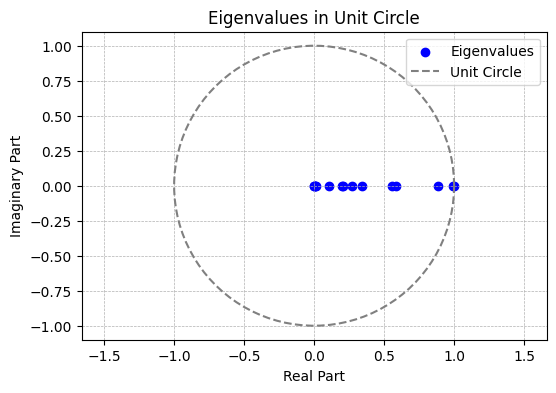

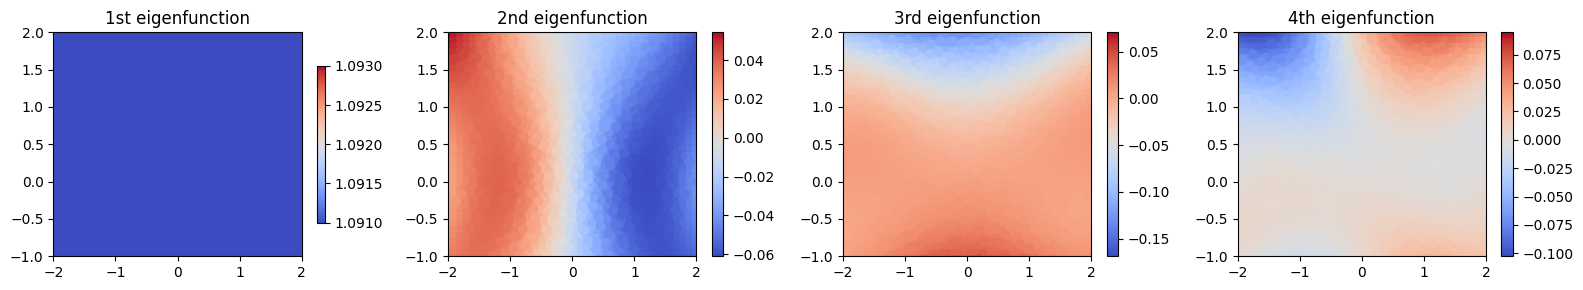

In [7]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])

plt.tight_layout()
plt.show()


In [8]:
# inner epoch = 50
# training step for fnn = 200